In [2]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('clean_dataset.csv')

# Shift target columns 1 step backward to represent "next day's return"
df['bitcoin_target'] = df['bitcoin_return'].shift(-1)
df['ethereum_target'] = df['ethereum_return'].shift(-1)
df['litecoin_target'] = df['litecoin_return'].shift(-1)

# Drop the last row (it will have NaN targets)
df = df.dropna()


In [15]:
feature_cols = [
    # prices
    'bitcoin_price', 'ethereum_price', 'litecoin_price',
    # volumes
    'bitcoin_volume', 'ethereum_volume', 'litecoin_volume',
    # log volumes
    'log_bitcoin_volume', 'log_ethereum_volume', 'log_litecoin_volume',
    # moving averages & volatility
    'bitcoin_ma7', 'ethereum_ma7', 'litecoin_ma7',
    'bitcoin_ma30', 'ethereum_ma30', 'litecoin_ma30',
    'bitcoin_volatility', 'ethereum_volatility', 'litecoin_volatility',
    # correlations
    'btc_eth_corr', 'btc_ltc_corr', 'ltc_eth_corr'
]
df['btc_direction'] = (df['bitcoin_target'] > 0).astype(int)
df['eth_direction'] = (df['ethereum_target'] > 0).astype(int)
df['ltc_direction'] = (df['litecoin_target'] > 0).astype(int)


target_cols = ['btc_direction', 'eth_direction', 'ltc_direction']

X = df[feature_cols]
y = df[target_cols]


In [16]:

# for time-series data the shuffle should be false
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [17]:

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)


In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd

# Make sure your y_train/y_test columns are 0/1 integers
# e.g., df['btc_direction'] = (df['bitcoin_target'] > 0).astype(int)

tscv = TimeSeriesSplit(n_splits=5)

# XGBoost classifier params (for trees)
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [3, 6, 8],
    'learning_rate': [0.03, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 5]
}

best_models = {}
pred_cls = {}
pred_proba = {}
rows = []

for coin in ['btc_direction', 'eth_direction', 'ltc_direction']:
    clf = XGBClassifier(
        random_state=42,
        tree_method='hist',        # fast
        eval_metric='logloss',     # required to silence warnings
        n_jobs=-1
    )

    grid = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring='accuracy',        # or 'roc_auc' if folds won’t be single-class
        cv=tscv,
        n_jobs=-1,
        refit=True,
        verbose=0
    )

    # NOTE: tree models don't need scaling; if you already scaled, it's fine but not necessary
    grid.fit(x_train_scaled, y_train[coin])

    best_models[coin] = grid.best_estimator_
    y_hat = grid.predict(x_test_scaled)
    y_proba = grid.predict_proba(x_test_scaled)[:, 1]

    pred_cls[coin] = y_hat
    pred_proba[coin] = y_proba

    # Metrics
    acc = accuracy_score(y_test[coin], y_hat)
    f1  = f1_score(y_test[coin], y_hat, zero_division=0)
    prec = precision_score(y_test[coin], y_hat, zero_division=0)
    rec  = recall_score(y_test[coin], y_hat, zero_division=0)
    # ROC-AUC can fail if a fold/test slice has a single class; guard it:
    try:
        auc = roc_auc_score(y_test[coin], y_proba)
    except ValueError:
        auc = np.nan

    cm = confusion_matrix(y_test[coin], y_hat)

    print(f"{coin} best params: {grid.best_params_}")
    print(f"{coin} -> Accuracy: {acc:.3f} | F1: {f1:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | ROC-AUC: {auc:.3f}")
    print(f"{coin} confusion matrix:\n{cm}\n")

    rows.append([coin, acc, f1, prec, rec, auc])

# Summary table
results_df = pd.DataFrame(rows, columns=['coin','accuracy','f1','precision','recall','roc_auc'])
print("Summary:\n", results_df)

# If you want a single DataFrame of predictions aligned to y_test:
pred_df = pd.DataFrame({f'{k}_pred': v for k, v in pred_cls.items()}, index=y_test.index)
proba_df = pd.DataFrame({f'{k}_proba': v for k, v in pred_proba.items()}, index=y_test.index)


btc_direction best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 1.0}
btc_direction -> Accuracy: 0.489 | F1: 0.590 | Precision: 0.486 | Recall: 0.750 | ROC-AUC: 0.551
btc_direction confusion matrix:
[[17 54]
 [17 51]]

eth_direction best params: {'colsample_bytree': 1.0, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 1.0}
eth_direction -> Accuracy: 0.547 | F1: 0.644 | Precision: 0.533 | Recall: 0.814 | ROC-AUC: 0.631
eth_direction confusion matrix:
[[19 50]
 [13 57]]

ltc_direction best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
ltc_direction -> Accuracy: 0.504 | F1: 0.517 | Precision: 0.507 | Recall: 0.529 | ROC-AUC: 0.533
ltc_direction confusion matrix:
[[33 36]
 [33 37]]

Summary:
             coin  accuracy        f1  precision    recall   roc_auc
0  btc_directi

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

best_model = grid.best_estimator_
best_params = grid.best_params_
best_cv_score = grid.best_score_

In [23]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# --- your existing grid search code above ---

# Combine predictions into a DataFrame
y_pred = pd.DataFrame(y_pred_dict, index=y_test.index)

# Evaluate each coin
results = {}
for coin in ['btc_direction', 'eth_direction', 'ltc_direction']:
    rmse = np.sqrt(mean_squared_error(y_test[coin], y_pred[coin]))
    r2 = r2_score(y_test[coin], y_pred[coin])
    results[coin] = {'RMSE': rmse, 'R2': r2}
    print(f"{coin}: RMSE = {rmse:.6f}, R² = {r2:.3f}")

# Optional: store all results in a DataFrame for easier comparison
results_df = pd.DataFrame(results).T
print("\nSummary of model performance:")
print(results_df)


btc_direction: RMSE = 0.541191, R² = -0.172
eth_direction: RMSE = 0.533113, R² = -0.137
ltc_direction: RMSE = 0.554628, R² = -0.231

Summary of model performance:
                   RMSE        R2
btc_direction  0.541191 -0.172098
eth_direction  0.533113 -0.136895
ltc_direction  0.554628 -0.230513


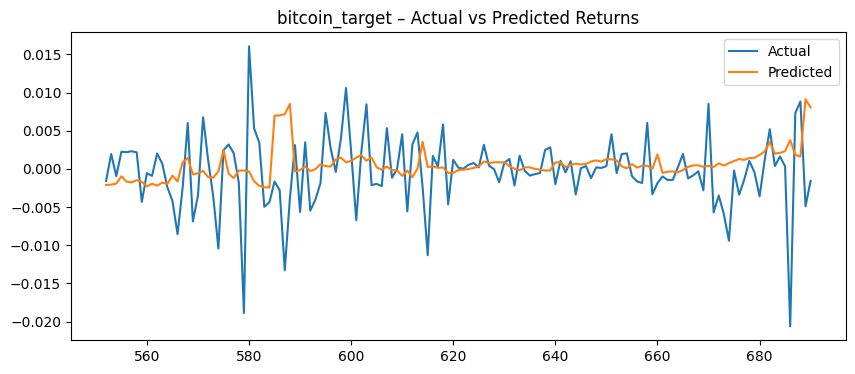

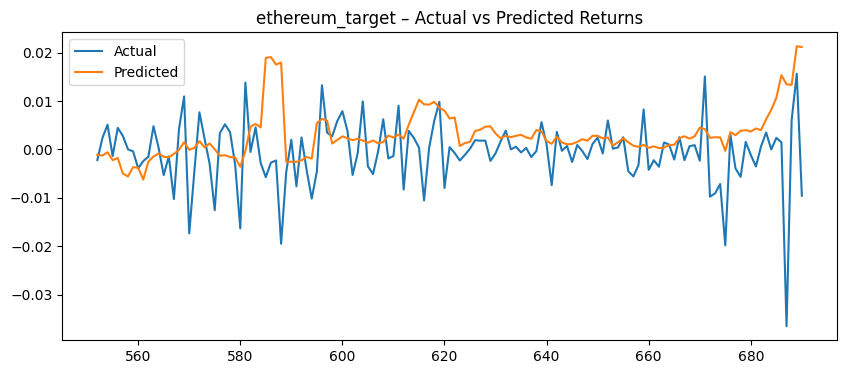

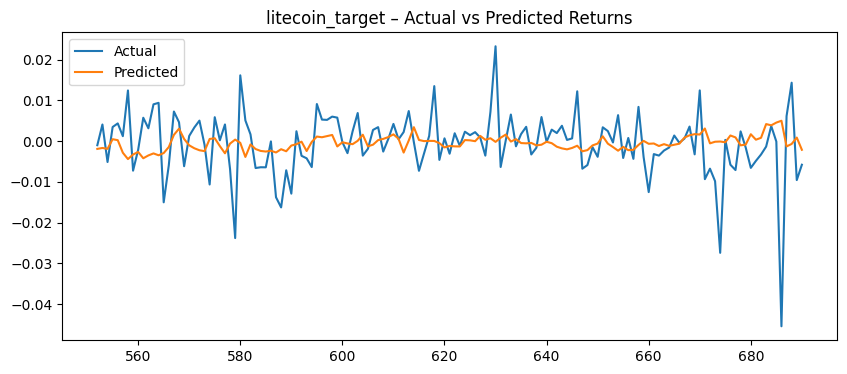

In [10]:
import matplotlib.pyplot as plt

for coin in y_test.columns:
    plt.figure(figsize=(10,4))
    plt.plot(y_test[coin], label='Actual')
    plt.plot(y_pred_df[coin], label='Predicted')
    plt.title(f'{coin} – Actual vs Predicted Returns')
    plt.legend()
    plt.show()
